# Homework #3 (Due 10/2/2019, 11:59pm)
## EM for Data Augmentation; MCMC Sampling

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name:** Rylan Schaeffer

**Students collaborators:** Dimitris Vamvourellis

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

---

# Problem Description: Latent Variables for Data Augmentation

A botany research lab in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to study the genetic factor that creates an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each. 

Out of 197 initial cross-breedings, the nursery obtained the following counts of the four types of child plants:

$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$

where $y_i$ represents the number of child plants that are of type $i$.

The geneticist in the lab know that the probability of obtaining each type of child plant in any single breeding experiment is correlated by the inheritability $\theta$ of a specific genetic factor. That is, the probabilities of obtaining the four subtypes are as follows:

$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4},$$

where $\theta \in [0, 1]$ is unknown.

The lab chose to model the observed data using a multinomial model:

\begin{align}
Y & \sim Mult\left(197, \left[\frac{\theta+2}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{align}

The aim of this problem is to estimate $\theta$ from the observed counts.

## Part I: MLE Through Latent Variable Augmentation and EM
In models where directly computing the MLE is hard (you can think about if that is the case here), the optimization of the likelihood can often be simplified by introducing a latent variable into the model and then optimize the liklelihood using EM - this process is called ***data augmentation***.

The nursery augmented the data with a new variable $Z$ such that:
$$Z + (y_1 - Z) = y_1.$$
That is, using $Z$, they are breaking $y_1$, the number of Type I child plants, into two subtypes, with $Z$ being the count of Subtype #1 and $(y_1-Z)$ being the count of Subtype #2. The lab posited the probability of obtain the two subtype $\theta/4$ and $1/2$, respectively.

The augmented model (which includes the observed data $y$ and the latent variable $z$ they introduced) they derived is as follows:

\begin{aligned}
Z | Y, \theta &\sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)\\
Y & \sim Mult\left(197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{aligned}

## Problem 1 Part 1 A
### Show that the assumptions the lab made about $Z$ implies that $Z | Y, \theta \sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)$.<br><br>

The first assumptions the lab made is that the plant can have two subtypes and that each plant is independently and identically distributed conditioned on $Y, \theta$, which means that a Binomial distribution is approrpriate. The second assumption is that the probability of the two classes are $p(Z=1) = p(z=1, y=1)= \theta/4$ and $p(Z=2) = p(z=2,y=1)= 1/2$. This results in a Binomial distribution with number of observations equal to $y_1$ and a probability of the first subclass equal to $p(z=1|y=1) = p(Z=1, Y=1)/P(Y=1) = p(Z=1, Y=1)/[p(Z=1, Y=1) + p(Z=2, Y=1)] = \frac{\theta/4}{1/2 + \theta/4} = \frac{\theta}{2 + \theta}$.

## Problem 1 Part 1 B
### Derive the EM updates for the augmented latent variable model.

In the E step, we set $q(z) = p(z|y, \theta)$. From Part 1 Problem 1, we know that for a given $\theta$, $q(z) \sim Bin(y_1, \frac{\theta}{2 + \theta})$. Thus, E-step consists of setting $q(z)$ equal to this distribution.

In the M step, we solves $argmax_{\theta} = \mathbb{E}_{q(z)}[\log p(z,y|theta)]$.

\begin{align}
\log p(z,y|\theta) &= \log [(1/2)^{y_1-z} (\theta/4)^{z+y_4} ((1-\theta)/4)^{y_2+y_3}]\\
\frac{\partial}{\partial \theta} \log p(z,y|\theta) = 0
&= 4(z + y_4)/\theta - 4(y_2 + y_3)/(1-\theta)\\
\theta &= \frac{z + y_4}{z+y_4+y_2+y_3}
\end{align}

## Problem 1 Part 1 C
### Implement the EM algorithm to estimate the MLE of $\theta$. Choose an appropriate initialization point and an appropriate stopping condition.

For my intialization of $z$, we know the the distribution will converge to have a low success rate since $\theta < 1$ and the probability of success is $\theta / (\theta + 2)$, so I chose to have few initial values of $z=1$ (15) and more initial values of $z=2$ (110) such that the sum was 125.

For the stopping condition, I decided to exponentially smooth $\theta$. Once the change in the moving average stopped was smaller than 0.01, I stopped iterating EM.

In [2]:
total_obs = 197

In [3]:
from numpy.random import binomial


# initial conditions (guess)
z_y = np.array([15, 110, 18, 20, 34])
theta = (z_y[1]+z_y[4]) / total_obs
print('Inital Joint Distribution: ', z_y)


def e_step(y_1, theta):
    q_parameters = (y_1, theta/(theta+2))
    return q_parameters


def m_step(obs, q_parameters):
    z_1 = binomial(n=q_parameters[0], p=q_parameters[1])
    z_2 = q_parameters[0] - z_1
    obs[0], obs[1] = z_1, z_2
    theta = (obs[0]+obs[4])/(np.sum(obs) - obs[1])
    return theta

smoothed_theta = 1.
alpha = 0.9
for i in range(100000):
    print('Iteration: {}, Theta: {}, Smoothed Theta: {}'.format(i, theta, smoothed_theta))
    q_parameters = e_step(125, theta=theta)
    theta = m_step(obs=z_y, q_parameters=q_parameters)
    new_smoothed_theta = alpha * theta + (1-alpha) * smoothed_theta
    if abs(new_smoothed_theta - smoothed_theta) < 0.001:
        break
    smoothed_theta = new_smoothed_theta
print('Final Smoothed Theta: {}'.format(new_smoothed_theta))

Inital Joint Distribution:  [ 15 110  18  20  34]
Iteration: 0, Theta: 0.7309644670050761, Smoothed Theta: 1.0
Iteration: 1, Theta: 0.6122448979591837, Smoothed Theta: 0.6510204081632653
Iteration: 2, Theta: 0.6637168141592921, Smoothed Theta: 0.6624471735596894
Iteration: 3, Theta: 0.6310679611650486, Smoothed Theta: 0.6342058824045127
Iteration: 4, Theta: 0.6481481481481481, Smoothed Theta: 0.6467539215737846
Iteration: 5, Theta: 0.6666666666666666, Smoothed Theta: 0.6646753921573785
Iteration: 6, Theta: 0.6237623762376238, Smoothed Theta: 0.6278536778295993
Iteration: 7, Theta: 0.6310679611650486, Smoothed Theta: 0.6307465328315037
Iteration: 8, Theta: 0.638095238095238, Smoothed Theta: 0.6373603675688646
Iteration: 9, Theta: 0.6122448979591837, Smoothed Theta: 0.6147564449201518
Iteration: 10, Theta: 0.638095238095238, Smoothed Theta: 0.6357613587777294
Iteration: 11, Theta: 0.6237623762376238, Smoothed Theta: 0.6249622744916343
Iteration: 12, Theta: 0.6513761467889908, Smoothed Th

## Problem 1 Part 1 D
### Explain the potential advantage of augmenting likelihood models with a latent variable (e.g. what aspects of the MLE computation becomes easier or more efficient?).

In general, one advantage of adding latent variables is the enhanced representational capacity of the model. For instance, most expontential family distributions are not multi-modal, meaning representing multimodal data can be difficult, but adding latent variables allows for mixture models, which makes more accurate modeling feasible.

In this particular case, by augmenting the likelihood with this latent variable, we were able to separate $y_1^{\theta/4 + 1/2}$ into $z_1^{\theta/4}*(y_1 - z)^{1/2}$. After taking the log and the derivative, the $(y_1 - z)^{1/2}$ disappears. This ensures that we only have $\theta^1$. In contrast, if we couldn't separate $y_1$'s exponent into two terms, we would've ended up with $\theta^2$ which is a harder equation to solve.

---

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on the mechanics of seting up a statistical model for this data set and performing inference on it. In the next homework, we will focus on interpreting this model and comparing it with others in context.**

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}

where $\alpha, \beta$ are hyper-parameters of the model.


Rather than arbitrarily choosing the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

In this problem, you will implement a modified Gibbs sampler to sample from the posterior of this complex model.

## Part I: The Conditional Distributions

## Problem 2 Part 1 A
### Justify our choice to use a hierarchical model. Specifically, explain the draw-backs of using MLE estimates of $\theta_j$ to represent the underlying cancer rates of these counties (recall the discussion in Lecture #3). Explain the draw-backs of choosing specific values for the hyper-parameters of $\alpha$ and $\beta$ rather than putting priors on them (recall the discussion in Homework #1 about priors).

I think there are several justifications for a hierarchical model. First, this model better reflects reality in that it permits cancer rates per county to differ county to county, but constrains per-county values to be (somewhat) akin to one another. Second, MLE in generally overfits, and this is particularly relevant here because smaller counties might have very small populations, so MLE will fit to counties in a way that isn't representative of the true occurrance of rates.

By placing priors on $\alpha, \beta$, we permit $\theta$'s distribution to evolve in response to the data, as opposed to being fixed without considering the data.

## Problem 2 Part 1 B
### Verify that the conditional distributions are 
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &= Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta),\\
p(\alpha, \beta | \theta, y) &\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
  where we use the following notation:
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_j\}_{j=1, j-1, j,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_j\}_{j=1, j-1, j,\ldots, N}\\
\end{align}
  Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.

Deriving the first conditional distribution $p(\theta_j|y_j, \alpha, \beta)$:

\begin{align}
p(\theta_j|y_j, \alpha, \beta)
&= \frac{p(\theta_j, y_j| \alpha, \beta)}{y_j}\\
&\propto p(\theta_j, y_j| \alpha, \beta)\\
&= Gamma(\alpha, \beta) Poisson(\theta_j)\\
&= \frac{\beta^{\alpha}}{\Gamma(\alpha)} \theta_j^{\alpha-1} e^{-\beta \theta_j} \frac{(5 n_j \theta_j)^{y_j} e^{-5n_j\theta_j}}{y_j !}\\
&\propto \theta_j^{\alpha-1} e^{-\beta \theta_j} \theta_j^{y_j} e^{-5n_j\theta_j}\\
&= \theta_j^{\alpha-1+y_j} e^{-(\beta + 5n_j)\theta_j}\\
&= Gamma(\alpha + y_j, \beta + 5 n_j)
\end{align}

Deriving now the second conditional distribution $p(\alpha, \beta | \theta, y)$:

\begin{align}
p(\alpha, \beta | \theta, y)
&= \frac{p(\alpha, \beta, \theta, y)}{p(\theta, y)}\\
&\propto p(\alpha, \beta, \theta, y)\\
&= p(\alpha) p(\beta)p(\theta | \alpha, \beta) p(y|\theta)\\
&= Gamma(a,b) Gamma(c,d) Gamma(\alpha, \beta) Poisson(4 n_j \theta_j)\\
&= \frac{b^a}{\Gamma(a)} \alpha^{a-1} e^{-b \alpha} \frac{d^c}{\Gamma(c)} \beta^{c-1} e^{-d \beta} \prod_{j=1}^N \theta_j^{\alpha-1} \frac{\beta^{\alpha}}{\Gamma(\alpha)} e^{-\beta \theta_j} \frac{(5 n_j \theta_j)^k e^{5 n_j \theta_j}}{k!}\\
&\propto \alpha^{a-1} e^{-b \alpha} \beta^{c-1} e^{-d \beta} \prod_{j=1}^N \theta_j^{\alpha-1} \frac{\beta^{\alpha}}{\Gamma(\alpha)} e^{-\beta \theta_j}\\
&= \Big[ \frac{\beta^{\alpha}}{\Gamma(\alpha)} \Big]^N  \Big[ \prod_{j=1}^N \theta_j^{\alpha-1} \Big] e^{-b \alpha -d \beta + \sum_j -\beta \theta_j} \alpha^{a-1} \beta^{c-1}
\end{align}

## Part II: Metropolis-Hastings-in-Gibbs
1. When one or more conditional distributions in a Gibbs sampler do not have closed forms (this is the case for most models), we often sample from these conditionals using another MCMC method (e.g. Metropolis Hastings). That is, we modify the Gibbs sampler as follows:

  **I.** Sample $\theta_j$ using the closed form for $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$.
  
  **II.** Sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a Metropolis-Hastings step (i.e. use a proposal distribution to propose a sample and the MH reject/accept mechanism to accept the new sample or keep the old).
  
  This algorithm is called a ***Metropolis-Hastings-in-Gibbs sampler***. <br><br>
  
  Note that we computed $p(\alpha, \beta | \theta, y)$ only up to a constant. Show why we don't need to know the normalizing constant of $p(\alpha, \beta | \theta, y)$ when we perform MH sampling.

When performing the MH step, the acceptance/rejection mechanism is determined by a ratio of two quantities (called $\alpha$ in the lecture notes):

$$\alpha(\theta_{\text{prop}}, \theta_{\text{old}}) = \min\left(1, \frac{p(\theta_{\text{prop}})/q(\theta_{\text{prop}} | \theta_{\text{old}})}{p(\theta_{\text{old}})/ q(\theta_{\text{old}}| \theta_{\text{prop}})}\right)$$

As noted above, we only know the true distribution $p(\alpha, \beta|\theta, y)$ up to a normalizing constant $C$; that is, we have $p'(\alpha, \beta|\theta, y)$, where $p(\alpha, \beta|\theta, y) = p'(\alpha, \beta|\theta, y) / C$. However, this normalizing constant is missing from both the numerator $p(\theta_{\text{prop}})$ and the denominator $p(\theta_{\text{old}})$. Even if we knew the normalizing constant and inserted into the equation, it would just cancel from the numerator and the denominator. Hence it doesn't matter.

## Problem 2 Part 2 A
### Implement and run a Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = 1.54517349188, \beta_0 = 133514.171939$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10<br><br>
  

In [4]:
import pandas as pd


kcancer = pd.read_csv('kcancer.csv')
num_counties = len(kcancer)
n = kcancer['pop'].values
y = kcancer['dc'].values

In [5]:
num_sweeps = 100000
a = 9
b = 6
c = 9
d = 0.00001
alpha = 1.54517349188
beta = 133514.171939
normal_cov = np.array([[0.1, 0], [0, 1000]])

In [6]:
import scipy


def calculate_log_p_ratio(alpha_beta_proposed, alpha_beta_old, theta):
    alpha_p, beta_p = alpha_beta_proposed
    alpha_o, beta_o = alpha_beta_old

    # print('Proposed: ', alpha_beta_proposed)
    # print('Old: ', alpha_beta_old)

    term_1 = num_counties*(alpha_p*np.log(beta_p) +
                           np.log(scipy.special.gamma(alpha_o)) -
                           alpha_o*np.log(beta_o) -
                           np.log(scipy.special.gamma(alpha_p)))
    # print('Term 1: ', term_1)
    term_2 = np.sum((alpha_p - alpha_o) * np.log(theta))
    # print('Term 2: ', term_2)
    term_3 = (a - 1) * np.log(alpha_p / alpha_o)
    # print('Term 3: ', term_3)
    term_4 = (c - 1) * np.log(beta_p / beta_o)
    # print('Term 4: ', term_4)
    term_5 = -b * (alpha_p - alpha_o) - d * (beta_p - beta_o) - (beta_p - beta_o) * np.sum(theta)
    # print('Term 5: ', term_5)
    log_p_ratio = term_1 + term_2 + term_3 + term_4 + term_5
    return log_p_ratio

In [7]:
from numpy.random import gamma, randint, uniform
from scipy.stats import multivariate_normal


accepted_samples = []
theta = (y+1.)/n

for sweep in range(num_sweeps):
    
    # choose random j and sample theta_j
    j = randint(low=0, high=num_counties)
    theta[j] = gamma(shape=alpha + y[j], scale=1./(beta+5*n[j]))
    
    # sample candidate alpha, beta
    alpha_beta_old = np.array([alpha, beta])
    alpha_beta_proposed = multivariate_normal.rvs(
        mean=alpha_beta_old,
        cov=normal_cov)
    
    # calculate unnormalized alpha, beta probabilities
    log_p_ratio = calculate_log_p_ratio(
        alpha_beta_proposed=alpha_beta_proposed,
        alpha_beta_old=alpha_beta_old,
        theta=theta)
    
    # calculate criterion (called alpha in the lecture notes)
    p_ratio = np.exp(log_p_ratio)
    if np.isinf(p_ratio):
        criterion = 1
    else:
        criterion = min(1., p_ratio)
#     print('Criterion: ', criterion)
    
    # sample uniform for acceptance/rejection
    if uniform() < criterion:
        alpha, beta = alpha_beta_proposed
    accepted_samples.append((alpha, beta))

/home/rylan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


In [8]:
accepted_samples = np.array(accepted_samples)
sweep_number = np.arange(num_sweeps)

In [9]:
# burn in i.e. drop first 10%
burn_in = .1
starting_index = int(num_sweeps * burn_in)
accepted_samples = accepted_samples[starting_index:]
sweep_number = sweep_number[starting_index:]

# thin every 10 steps
thinning = 10
accepted_samples = accepted_samples[::thinning]
sweep_number = sweep_number[::thinning]

## Problem 2 Part 2 B
### Check for and discuss the convergence of your sampler. If you think your sampler has converged, explain why. If you believe your sampler has not converged, explain what next steps you might take to determine which design choices were problemmatic.
  
  **Important Disclaimer:** Convergence in a untweaked sampler may be unlikely after only 100,000 Gibbs sweeps. We are not asking you in this homework to achieve convergence, but you must demonstrate that you know how to perform diagnostics on your sampler.

As the plots below reveal, I don't think that my sampler has converged for two reasons. First, both $\beta$ and $\alpha$ still have trends, especially $\beta$. Second, if I let the sampler run for longer, samples continue to trend upwards.

My next steps would be to try a variety of remedies. I might try running the sampler for longer, or running multiple samplers from different initial conditions. I might increase the variance for the proposal distribution, at least initially, to see which direction the sampler moves towards.

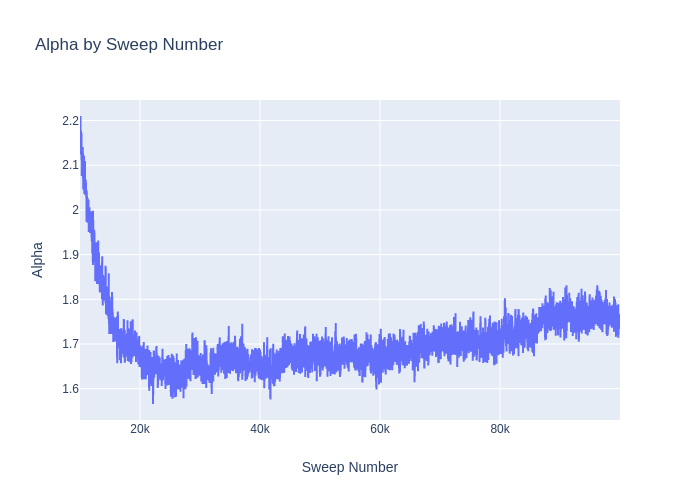

In [10]:
from IPython.display import Image
import plotly
import plotly.graph_objects as go
import plotly.io as pio

# visualize alpha
data = [
    go.Scatter(x=sweep_number,
               y=accepted_samples[:, 0],
               mode="lines",
               name="alpha"),
    ]

layout = dict(
    title="Alpha by Sweep Number",
    xaxis=dict(title="Sweep Number"),
    yaxis=dict(title="Alpha")
)

fig = go.Figure(
    data=data,
    layout=layout)

Image(pio.to_image(fig, format='png'))

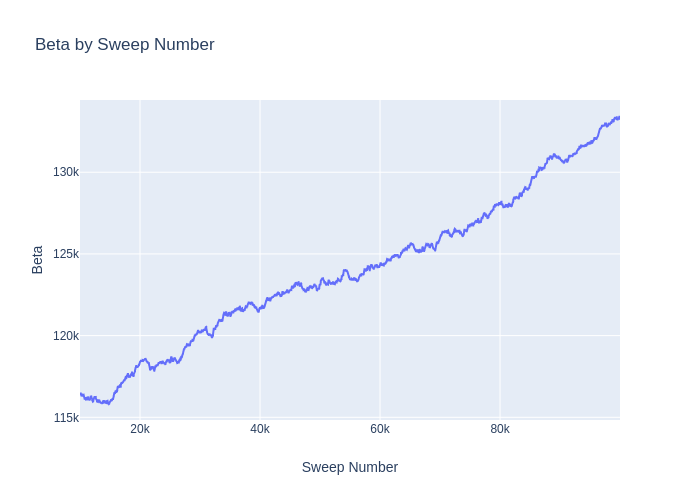

In [11]:
# visualize beta

data = [
    go.Scatter(x=sweep_number,
               y=accepted_samples[:, 1],
               mode="lines",
               name="beta"),
    ]

layout = dict(
    title="Beta by Sweep Number",
    xaxis=dict(title="Sweep Number"),
    yaxis=dict(title="Beta")
)

fig = go.Figure(
    data=data,
    layout=layout)

Image(pio.to_image(fig, format='png'))

**Extra Credit:** Prove the correctness of Metropolis-Hastings-in-Gibbs sampler. You need to state the definition of the correctness of an MCMC sampler and prove that Metropolis-Hastings-in-Gibbs sampler satisfy these properties.

From the Lecture 6 notes, 3 criteria must be met for an MCMC sampler to be correct:

1. The sampler defines an **irreducible** chain: a sufficient condition is that for any $\theta' \in \Theta$

$$
q(\theta| \theta') > 0,\; \text{for all } \theta \in \Theta.
$$

The first condition is easily met. Metropolis-Hastings-in-Gibbs samples from all elements in $\theta$, where the distribution for each $\theta_j$ covers the entire possible support. Similarly, $\alpha$ and $\beta$ are sampled from Normal distributions, which covers the entire real number line, so all possible values can be sampled. Thus, we conclude that there is a non-zero probability for all possible next setting of the parameters.

2. The sampler defines an **aperiodic** chain: a sufficient condition is that for any $\theta' \in \Theta$

$$
q(\theta | \theta') > 0, \text{for all $\theta$ is a small neighbourhood around $\theta'$}.
$$

The second condition is also met. Our MH proposal distribution has a very tight covariance compared to the magnitude of the means i.e. Var($\alpha$) = 0.1 << Mean($\alpha$) = 1.5 and Var($\beta$) = $10^3$ << Mean($\beta$) = $1.3*10^5$. This ensures we have a small neighborhood around $\theta'$ when sampling the next $\theta$.

3. The sampler defines an **reversible** chain (i.e. **detailed balance** is satisfied) with respect to $p$:

$$
p(\theta')T_{\text{MH-in-Gibbs}}(\theta', \theta) = T_{\text{MH-in-Gibbs}}(\theta, \theta') p(\theta)
$$

The transition kernel for Metropolis-Hastings is a normal distribution, and since two normal distributions with means at two points are symmetric i.e. $\theta \sim N(\theta') = \theta' \sim N(\theta)$, we have that detailed balance is satisfied. Since $p(\theta_j)$ is sampled from fixed $\alpha, \beta$, we also ensure that $p(\theta_i) = p(\theta_j)$.

**Extra Credit:** Tweak the settings in your sampler (e.g. number of sweeps) in order to achieve reasonable confidence that your sampler has converged. Reconsider also other design choices like, do you need to sample $\alpha$ and $\beta$ jointly?

I'm reasonably certain that my sampler has converged below since $\alpha$ and $\beta$ both asymptote towards a constant number. There are several design choices to make the sampler converges more quickly. One option is increasing the number of sweeps significantly, but this takes tremendous additional time. Another option is changing the initial values of $\alpha$ and $\beta$ to the ending values of a previous run (in essence, running 1 long chain instead of two shorter ones). Other options might include changing the covariance of the proposal distribution or the number of sampled $\theta_j$s per iteration. Sampling $\alpha$ and $\beta$ jointly is not necessary. To see why, note that a diagonal covariance matrix is equivalent to sampling from two univariate Gaussians.

Dimitris made a good observation that because the mean of a Gamma distribution is $\alpha/\beta$, which means that the two parameters will "chase" one another to preserve a good balance. This is made extra hard because $\alpha$ is so small compared to $\beta$. As a result, adding entries to the covariance matrix stabilizes the sampler. I'm not sure whether this is the right thing to do, but it appears to stabilize the samples.

In [12]:
accepted_samples = []
theta = (y+1.)/n
num_sweeps = 1000000

alpha = 5.3  # previously 1.54517349188
beta = 520000  # previously 133514.171939
normal_cov = np.array([[0.1, 10], [10, 1000]])  # previously [[0.1, 0], [0, 1000]]

for sweep in range(num_sweeps):
    
    # choose random j and sample theta_j
    j = randint(low=0, high=num_counties)
    theta[j] = gamma(shape=alpha + y[j], scale=1./(beta+5*n[j]))
    
    # sample candidate alpha, beta
    alpha_beta_old = np.array([alpha, beta])
    alpha_beta_proposed = multivariate_normal.rvs(
        mean=alpha_beta_old,
        cov=normal_cov)
    
    # calculate unnormalized alpha, beta probabilities
    log_p_ratio = calculate_log_p_ratio(
        alpha_beta_proposed=alpha_beta_proposed,
        alpha_beta_old=alpha_beta_old,
        theta=theta)
    
    # calculate criterion (called alpha in the lecture notes)
    p_ratio = np.exp(log_p_ratio)
    if np.isinf(p_ratio):
        criterion = 1
    else:
        criterion = min(1., p_ratio)
    
    # sample uniform for acceptance/rejection
    if uniform() < criterion:
        alpha, beta = alpha_beta_proposed
    accepted_samples.append((alpha, beta))


/home/rylan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning:

overflow encountered in exp



In [13]:
accepted_samples = np.array(accepted_samples)
sweep_number = np.arange(num_sweeps)

# burn in i.e. drop first 10%
burn_in = .1
starting_index = int(num_sweeps * burn_in)
accepted_samples = accepted_samples[starting_index:]
sweep_number = sweep_number[starting_index:]

# thin every 10 steps
thinning = 1000
accepted_samples = accepted_samples[::thinning]
sweep_number = sweep_number[::thinning]

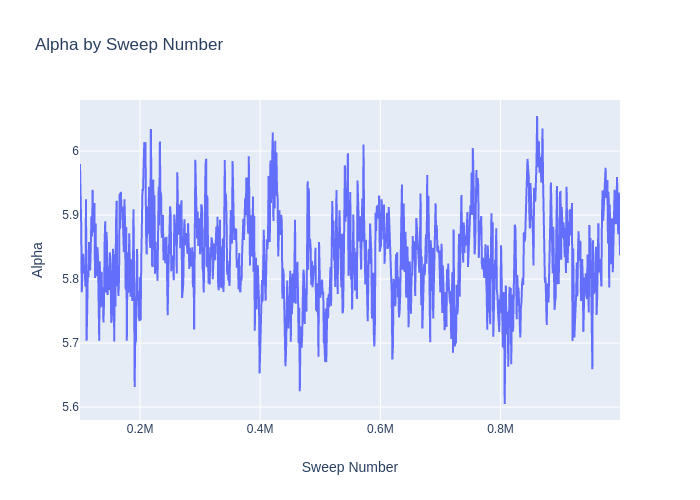

In [14]:
# visualize alpha
data = [
    go.Scatter(x=sweep_number,
               y=accepted_samples[:, 0],
               mode="lines",
               name="alpha"),
    ]

layout = dict(
    title="Alpha by Sweep Number",
    xaxis=dict(title="Sweep Number"),
    yaxis=dict(title="Alpha")
)

fig = go.Figure(
    data=data,
    layout=layout)

Image(pio.to_image(fig, format='png'))


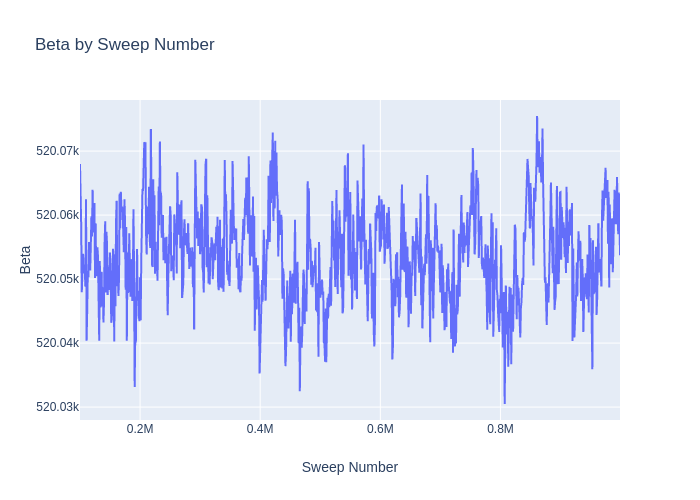

In [15]:
# visualize beta
data = [
    go.Scatter(x=sweep_number,
               y=accepted_samples[:, 1],
               mode="lines",
               name="beta"),
]

layout = dict(
    title="Beta by Sweep Number",
    xaxis=dict(title="Sweep Number"),
    yaxis=dict(title="Beta")
)

fig = go.Figure(
    data=data,
    layout=layout)

Image(pio.to_image(fig, format='png'))